In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Introduction to Visualization:
Density Estimation and Data Exploration
========

##### Version 0.2

There are many flavors of data analysis that fall under the "visualization" umbrella in astronomy. Today, by way of example, we will focus on 2 basic problems.

***
By AA Miller (Northwestern/CIERA)  
30 August 2023


## Problem 1) Density Estimation

Starting with 2MASS and SDSS and extending through to the Rubin Observatory, we are firmly entrenched in an era where data and large statistical samples are cheap. With this explosion in data volume comes a problem: we do not know the underlying probability density function (PDF) of the random variables measured via our observations. 

Hence - density estimation: an attempt to recover the unknown PDF from observations. In some cases theory can guide us to a parametric form for the PDF, but more often than not such guidance is not available. 

There is a common, simple, and very familiar tool for density estimation: histograms. 

But there is also a problem:

HISTOGRAMS LIE!

We will "prove" this via example. For this exercise, we will load the famous Linnerud data set, which tested 20 middle aged men by measuring the number of chinups, situps, and jumps they could do in order to compare these numbers to their weight, pulse, and waist size. Execute the cell below to load the data (just chinups for now).

In [2]:
from sklearn.datasets import load_linnerud

linnerud = load_linnerud()
chinups = linnerud.data[:,0]

**Problem 1a** 

Plot the histogram for the number of chinups using the default settings in pyplot.

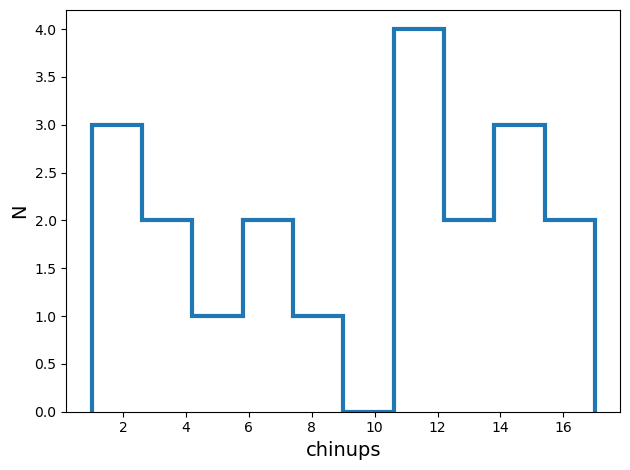

In [3]:
fig, ax = plt.subplots()
ax.hist(chinups, histtype = "step", lw = 3) # complete
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

Something is wrong here - the choice of bin centers and number of bins suggest that there is a 0% probability that middle aged men can do 10 chinups. This is intuitively incorrect; we will now adjust the bins in the histogram.


**Problem 1b** 

Using the same data make 2 new histograms: (i) one with 5 bins (`bins = 5`), and (ii) one with the bars centered on the left bin edges (`align = "left"`).

*Hint - if overplotting the results, you may find it helpful to use the `histtype = "step"` option*

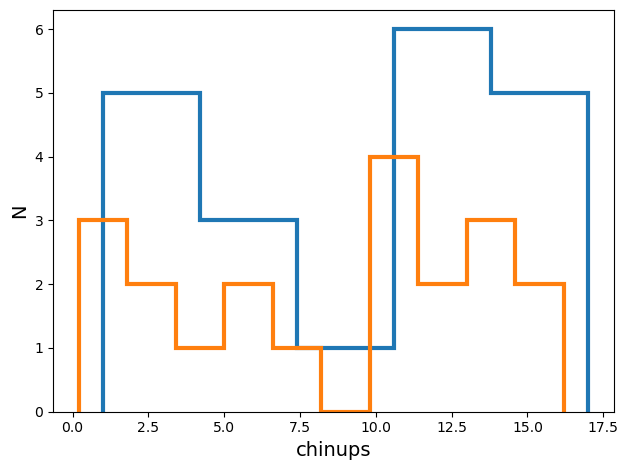

In [4]:
fig, ax = plt.subplots()
ax.hist(chinups, histtype = "step", lw = 3, bins = 5) # complete
ax.hist(chinups, histtype = "step", lw = 3, align = "left") # complete
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

These small changes significantly change the estimator for the PDF. With fewer bins we get something closer to a continuous distribution, while shifting the bin centers reduces the probability to zero at 9 chinups. 

What if we instead allow the bin width to vary and require the same number of points in each bin? You can determine the bin edges for bins with 5 sources using the following command:

`bins = np.append(np.sort(chinups)[::5], 
                  np.max(chinups))`

**Problem 1c** 

Plot a histogram with variable width bins, each with the same number of points.

*Hint - setting `density = True` will normalize the bin heights so that the PDF integrates to 1.*

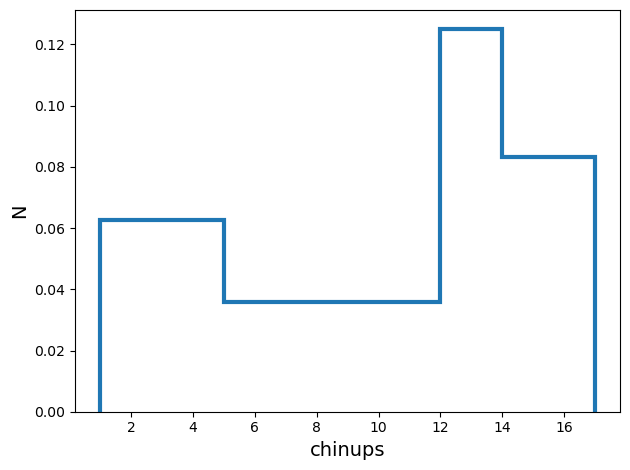

In [5]:
bins = np.append(np.sort(chinups)[::5], 
                  np.max(chinups))# complete
fig, ax = plt.subplots()
ax.hist(chinups, histtype = "step", lw = 3,
        bins = bins, density = True) # complete
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

*Ending the lie* 

Histograms lie, tell the "truth": show all the data. Viewers can understand the effects of bin choices when all the data are shown (this is cumbersome for very large data, which is essentially all modern data sets).  Adding a rug plot, which shows a vertical tick for each source, provides additional clarity.

**Problem 1d** 

Execute the cell below to see an example of a rug plot. 

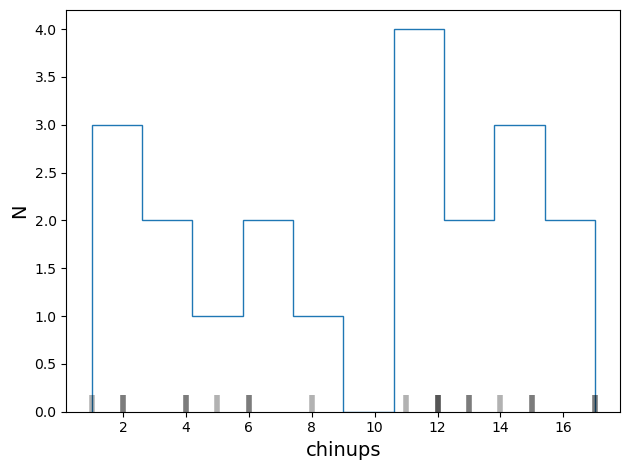

In [6]:
fig, ax = plt.subplots()
ax.hist(chinups, histtype = 'step')

# this is the code for the rug plot
ax.plot(chinups, np.zeros_like(chinups), '|', 
        color='k', ms = 25, mew = 4, alpha = 0.3)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

Rug plots are also imperfect. What if a measurement is repeated? A (slightly) better solution is to vary the transparency of the rug "whiskers" using `alpha = 0.3`. But this too is far from perfect. 

To recap, histograms are not ideal for density estimation: 

* They introduce discontinuities that are not present in the data
* They are strongly sensitive to user choices ($N_\mathrm{bins}$, bin centering, bin grouping), without any mathematical guidance to what these choices should be
* They are difficult to visualize in higher dimensions

Histograms are useful for generating a quick representation of univariate data, but for the reasons listed above they should never be used for analysis. Most especially, functions should not be fit to histograms given how greatly the number of bins and bin centering affects the output histogram.

There must be a better option!

(sound of slowly building classical music) Enter: [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE). 

KDE is a nonparametric form of density estimation whereby a normalized kernel function is convolved with discrete data to obtain a continuous estimate of the underlying PDF. As a rule, the kernel must integrate to 1 over the interval $-\infty$ to $\infty$ and be symmetric. There are many possible kernels (gaussian is highly popular, though Epanechnikov, an inverted parabola, produces the minimal mean square error). 

KDE is not completely free of the problems we illustrated for histograms above (in particular, both a kernel and the width of the kernel need to be selected), but it does manage to correct a number of the ills. We will now demonstrate this via a few examples using the `scikit-learn` implementation of KDE: [`KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity), which is part of the [`sklearn.neighbors`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) module. 

*Note* There are many implementations of KDE in Python, and Jake VanderPlas has put together [an excellent description of the strengths and weaknesses of each](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/).

To demonstrate the basic idea behind KDE, we will begin by representing each point in the dataset as a block (i.e. we will adopt the tophat kernel). Borrowing some code from Jake, we can estimate the KDE using the following code:

    from sklearn.neighbors import KernelDensity
    def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
        kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
        kde_skl.fit(data[:, np.newaxis])
        log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)
        
        return np.exp(log_pdf)
        
The two main options to set are the bandwidth and the kernel. 

In [7]:
# execute this cell
from sklearn.neighbors import KernelDensity
def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

**Problem 1e** 

Plot the KDE of the PDF for the number of chinups middle aged men can do using a bandwidth of 0.1 and a tophat kernel.

*Hint - as a general rule, the grid should be smaller than the bandwidth when plotting the PDF (i.e., >200 points in this case)*

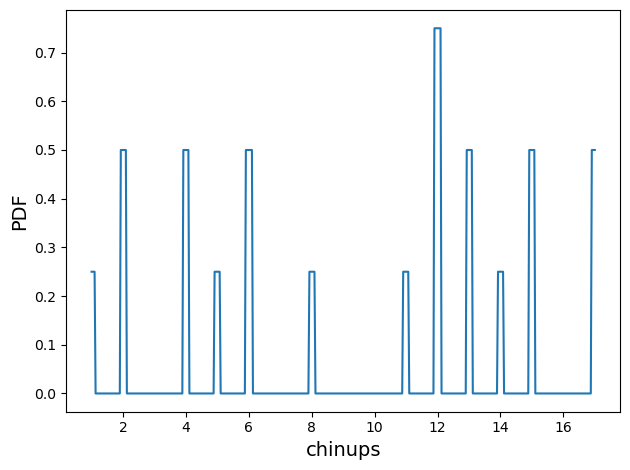

In [8]:
grid = np.linspace(np.min(chinups), np.max(chinups), 500)# complete
PDFtophat = kde_sklearn(chinups, grid, bandwidth = 0.1, kernel = "tophat") # complete

fig, ax = plt.subplots()
ax.plot(grid, PDFtophat) # complete
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()

In this representation, each "block" has a height of 0.25. The bandwidth is too narrow to provide any overlap between the blocks. This choice of kernel and bandwidth produces an estimate that is essentially a histogram with a large number of bins. It gives no sense of continuity for the distribution. Now, we examine the difference (relative to histograms) upon changing the the width (i.e. kernel) of the blocks. 

**Problem 1f** 

Plot the KDE of the PDF for the number of chinups middle aged men can do using bandwidths of 1 and 5 and a tophat kernel. 

How do the results differ from the histogram plots above? 

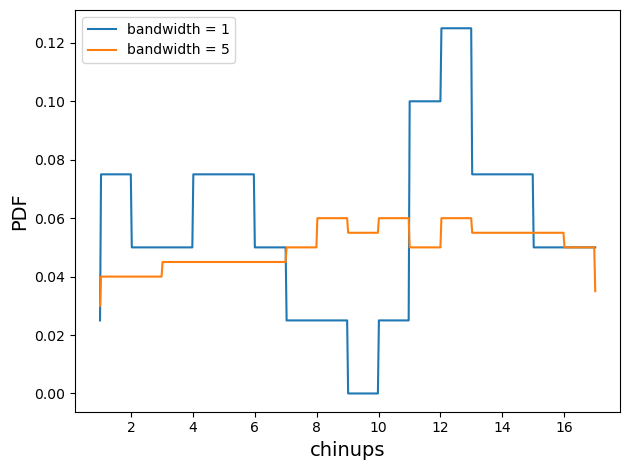

In [9]:
PDFtophat1 = kde_sklearn(chinups, grid, bandwidth = 1., kernel = "tophat") # complete
PDFtophat5 = kde_sklearn(chinups, grid, bandwidth = 5., kernel = "tophat") # complete

fig, ax = plt.subplots()
ax.plot(grid, PDFtophat1, label='bandwidth = 1') # complete
ax.plot(grid, PDFtophat5, label='bandwidth = 5') # complete
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()
ax.legend()

It turns out blocks are not an ideal representation for continuous data (see discussion on histograms above). Now we will explore the resulting PDF from other kernels. 

**Problem 1g** Plot the KDE of the PDF for the number of chinups middle aged men can do using a gaussian and Epanechnikov kernel. How do the results differ from the histogram plots above? 

*Hint - you will need to select the bandwidth. The examples above should provide insight into the useful range for bandwidth selection. You may need to adjust the values to get an answer you "like."*

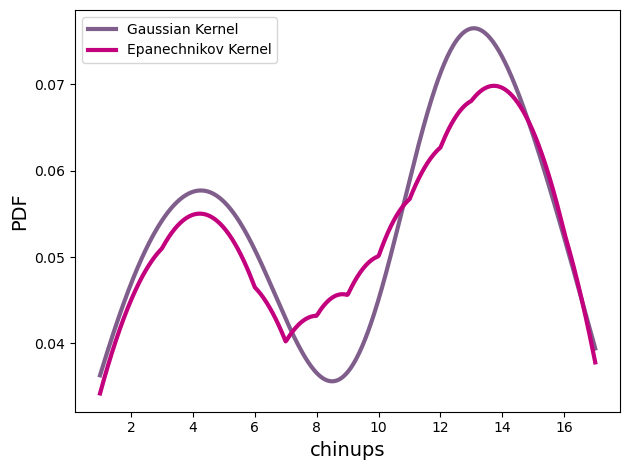

In [10]:
PDFgaussian = kde_sklearn(chinups, grid, bandwidth = 2., kernel = "gaussian") # complete
PDFepanechnikov = kde_sklearn(chinups, grid, bandwidth = 5., kernel = "epanechnikov") # complete

colors = ["#805e8c", "#c3007d"]

fig, ax = plt.subplots()
ax.plot(grid, PDFgaussian, lw = 3,
        label = 'Gaussian Kernel', color = colors[0]) # complete
ax.plot(grid, PDFepanechnikov, lw = 3,
        label = 'Epanechnikov Kernel', color = colors[1]) # complete
ax.legend(loc = 2)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()

So, what is the *optimal* choice of bandwidth and kernel? 

Unfortunately, every problem will likely have a different optimization. Typically, bandwidth is far more important than the choice of kernel. If the PDF is likely to be gaussian (or close to gaussian), then [Silverman's rule of thumb](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator) can be used: 

$$h = 1.059 \sigma n^{-1/5}$$

where $h$ is the bandwidth, $\sigma$ is the standard deviation of the samples, and $n$ is the total number of samples. Note - in situations with bimodal or more complicated distributions, this rule of thumb can lead to woefully inaccurate PDF estimates. The most general way to estimate the choice of bandwidth is via cross validation (we will cover cross-validation during the session on Machine Learning). 

*What about multidimensional PDFs?* It is possible using many of the Python implementations of KDE to estimate multidimensional PDFs, though it is very very important to beware the curse of dimensionality in these circumstances.

## Problem 2) Data Exploration

Data exploration encompases a large suite of tools to examine large dimensional spaces. There is no single best method for data exploration. 

As an example we will start with a basic line plot - and examine tools beyond `matplotlib`.

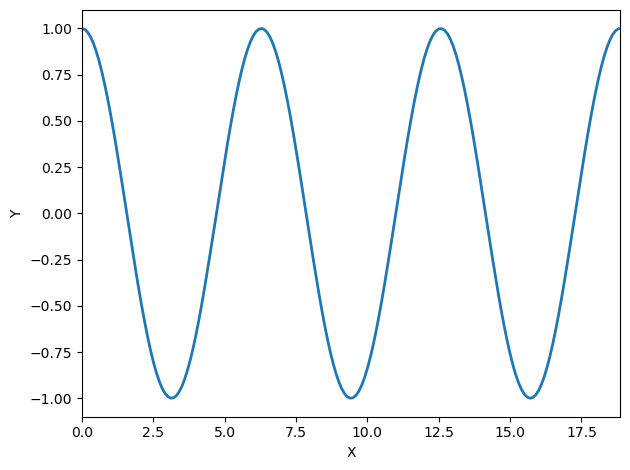

In [11]:
x = np.arange(0, 6*np.pi, 0.1)
y = np.cos(x)

fig, ax=plt.subplots()
ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)
fig.tight_layout()

### Seaborn

[`Seaborn`](https://stanford.edu/~mwaskom/software/seaborn/index.html) is a plotting package that enables many useful features for exploration. 

Built-in tools in `seaborn` can reproduce everything from **Problem 1** in a single call.

Recreate the above `matplotlib` plot using `Seaborn`. 

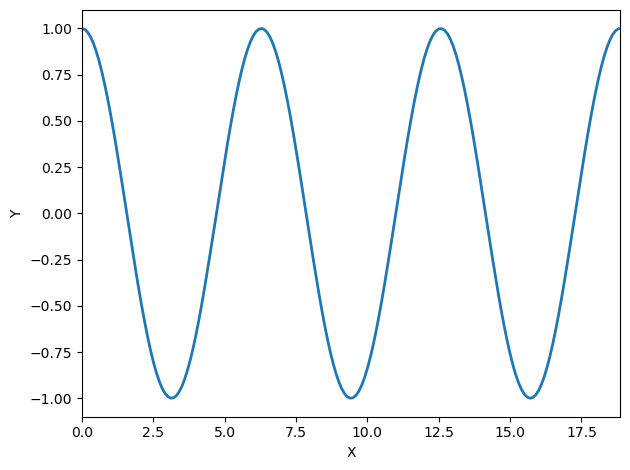

In [12]:
import seaborn as sns

fig, ax = plt.subplots()

ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)
fig.tight_layout()

These plots look identical, but it is possible to change the style with `seaborn`. 

`seaborn` has 5 style presets: `darkgrid`, `whitegrid`, `dark`, `white`, and `ticks`. You can change the preset using the following: 

    sns.set_style("whitegrid")
 
which will change the output for all subsequent plots. Note - if you want to change the style for only a single plot, that can be accomplished with the following: 

    with sns.axes_style("dark"):

with all ploting commands inside the `with` statement. 

**Problem 2a** 

Re-plot the sine curve using each `seaborn` preset to see which you like best - then adopt this for the remainder of the notebook. 

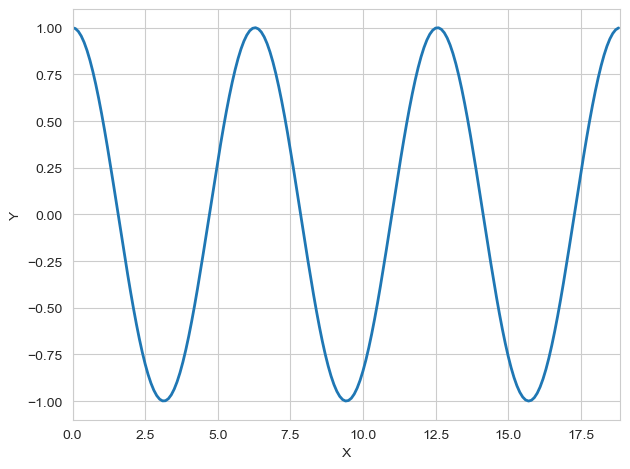

In [18]:
sns.set_style('whitegrid')

fig, ax = plt.subplots()

ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)
fig.tight_layout()

The `seaborn` devs have thought a lot about color palettes.

A poor choice of colors can easily mask interesting patterns or suggest structure that is not real. To learn more about what is available, see the [`seaborn` color tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html). 

Here we load the default:

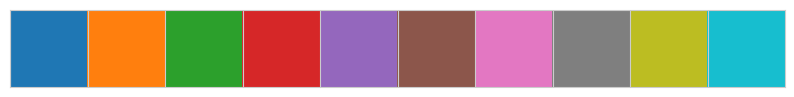

In [19]:
# default color palette

current_palette = sns.color_palette()
sns.palplot(current_palette)

which we will now change to `colorblind`, which is clearer to those that are colorblind.

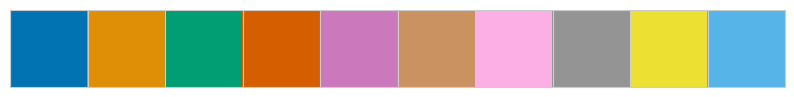

In [20]:
# set palette to colorblind
sns.set_palette("colorblind")

current_palette = sns.color_palette()
sns.palplot(current_palette)

Beyond the basics (we barely scratched the surface), `seaborn` is also powerful for higher dimension data sets. 

The famous Iris data set, which measures 4 different features of 3 different types of Iris flowers, will be our focus for the remainder of this notebook. There are 150 different flowers in the data set.

*Note - for those familiar with `pandas` `seaborn` is designed to integrate easily and directly with `pandas DataFrame` objects. In the example below the Iris data are loaded into a `DataFrame`. `iPython` notebooks also display the `DataFrame` data in a nice readable format.* 

In [21]:
iris = sns.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We went to great pains to produce histograms, KDEs, and rug plots in **Problem 1**. `seaborn` handles all of that effortlessly with the [`displot`](https://seaborn.pydata.org/generated/seaborn.displot.html) function.

**Problem 2b** 

Plot the distribution of petal lengths for the Iris data set. 

/Users/daniel/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_80877/197016540.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


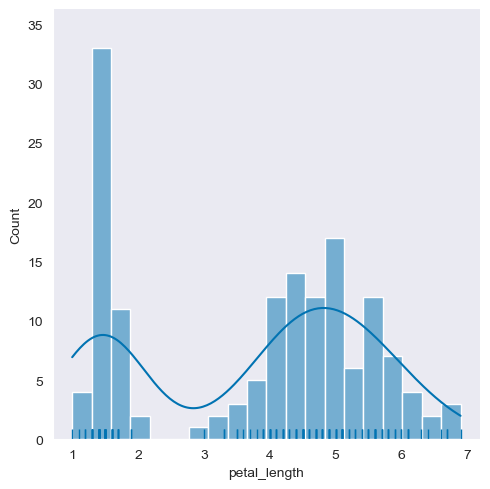

In [22]:
# note - kde, and rug all set to True, set to False to turn them off 
with sns.axes_style("dark"):
    sns.displot(iris['petal_length'], bins=20, 
                kde=True, rug=True)
plt.tight_layout()

The Iris data lives in a 4D space, so plotting more than univariate distributions is important. Fortunately, `seaborn` makes it easy to produce handy summary plots (in a way that is far more comprehensive than `matplotlib`). 

**Problem 2c** 

Make a matplotlib scatter plot showing the Iris petal length against the Iris petal width.

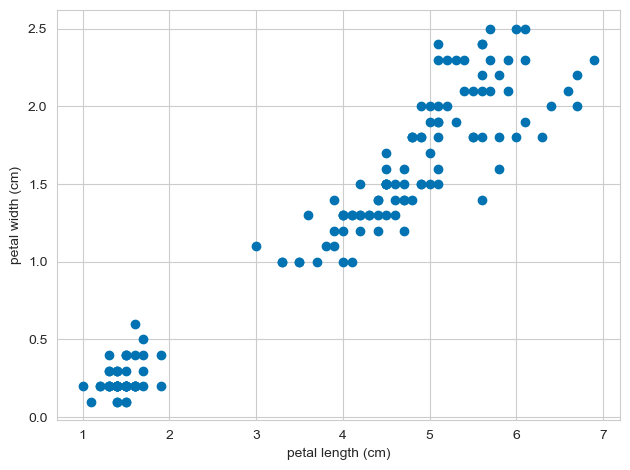

In [23]:
fig, ax = plt.subplots()
ax.scatter(iris['petal_length'], iris['petal_width']) 
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")
fig.tight_layout()

**Aside**

When there are many many data points, scatter plots become difficult to interpret. 

Execute the cell below:

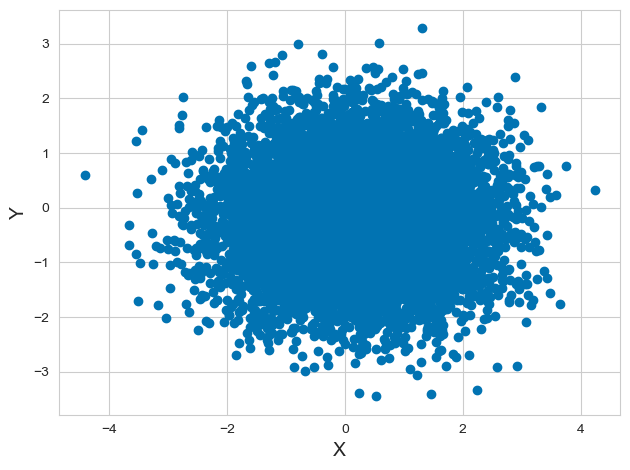

In [24]:
np.random.seed(2016)
xexample = np.random.normal(loc = 0.2, scale = 1.1, size = 10000)
yexample = np.random.normal(loc = -0.2, scale = 0.9, size = 10000)

fig, ax = plt.subplots()
ax.scatter(xexample, yexample)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()

Here, we see that there are many points, clustered about the origin, but we have no sense of the underlying density of the distribution. 2D histograms, such as `plt.hist2d()`, can alleviate this problem. I prefer to use `plt.hexbin()` which is a little easier on the eyes (though note - these histograms are just as subject to the same issues discussed above). 

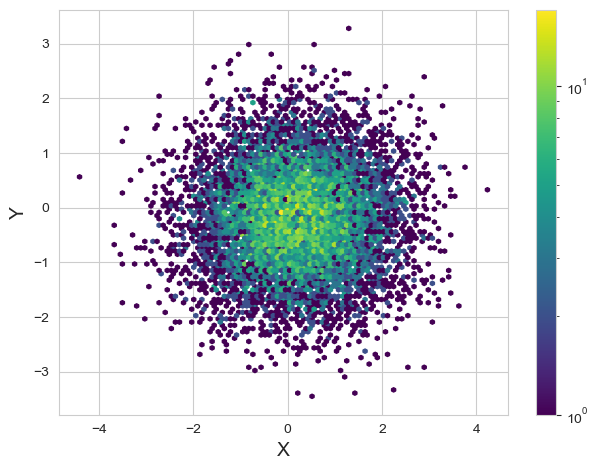

In [25]:
# hexbin w/ bins = "log" returns the log of counts/bin
# mincnt = 1 displays only hexpix with at least 1 source present
fig, ax = plt.subplots()
cax = ax.hexbin(xexample, yexample, bins = "log", cmap = "viridis", mincnt = 1)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()
plt.colorbar(cax)

While the above plot provides a significant improvement over the scatter plot by providing a better sense of the density near the center of the distribution, the binedge effects are clearly present. Similar to **1g** a density estimate is superior. KDEs are easy in `seaborn` via the `kdeplot` function.

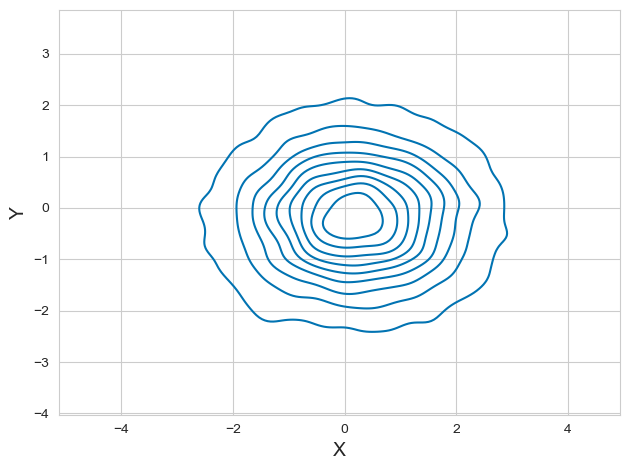

In [27]:
fig, ax = plt.subplots()
sns.kdeplot(x=xexample, y=yexample, fill=False)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()

This plot is much more appealing (and informative) than the previous two. For the first time we can clearly see that the distribution is not actually centered on the origin. Now we will move back to the Iris data set. 

Suppose we want to see univariate distributions in addition to the scatter plot? This is certainly possible with `matplotlib` and you can find examples on the web, however, with `seaborn` this is really easy.

/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_80877/2589227462.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


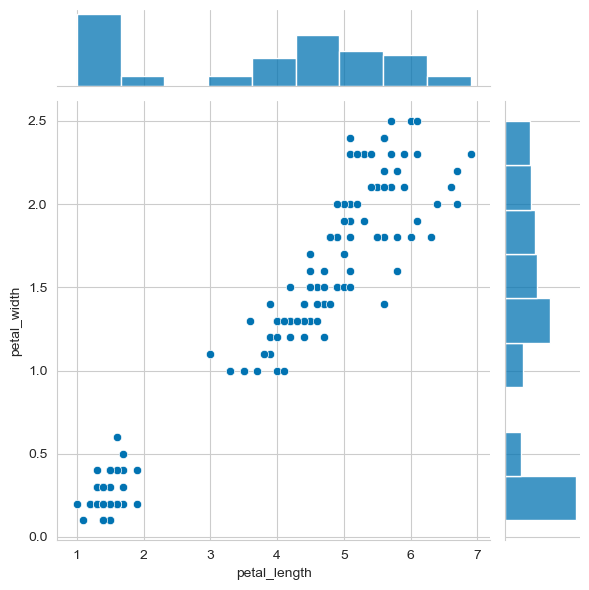

In [28]:
sns.jointplot(x=iris['petal_length'], y=iris['petal_width'])
plt.tight_layout()

But! Histograms and scatter plots can be problematic as we have discussed many times before. 

**Problem 2d** 

Re-create the plot above but set `kind='kde'` to produce density estimates of the distributions.

/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_80877/4132638415.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


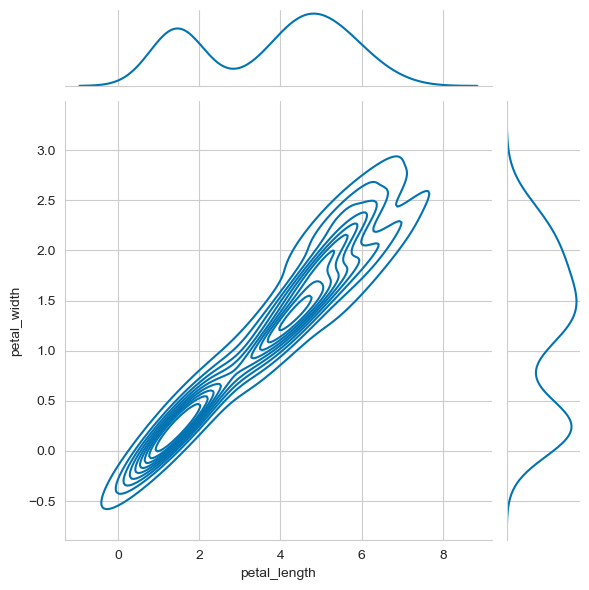

In [31]:
sns.jointplot(x=iris['petal_length'], y=iris['petal_width'], kind='kde')
plt.tight_layout()

That is much nicer than what was presented above. However - we still have a problem in that our data live in 4D, but we are (mostly) limited to 2D projections of that data. One way around this is via the `seaborn` version of a `pairplot`, which plots the distribution of every variable in the data set against each other. (Here is where the integration with `pandas DataFrame`s becomes so powerful.)

/Users/daniel/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_80877/3639937624.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


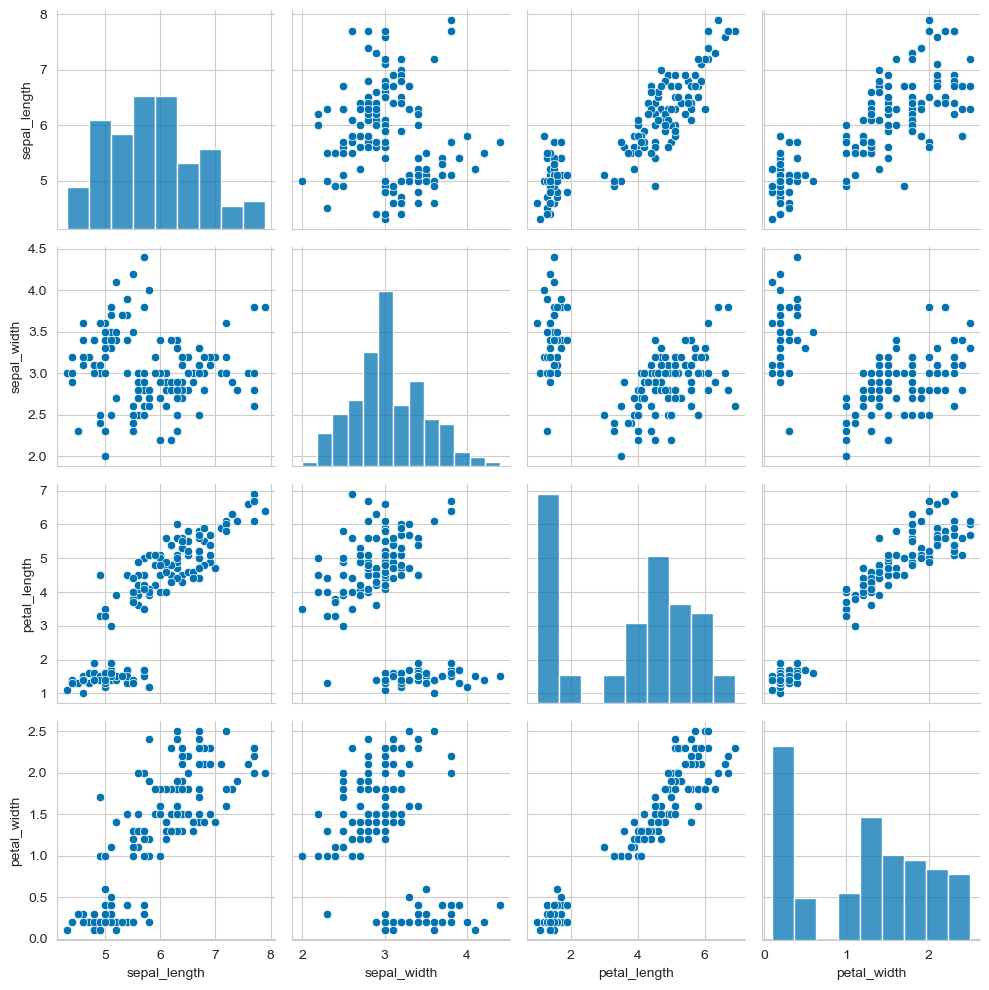

In [32]:
sns.pairplot(iris[["sepal_length", "sepal_width", 
                   "petal_length", "petal_width"]])
plt.tight_layout()

For data sets where we have classification labels, we can even color the various points using the `hue` option, and produce KDEs along the diagonal with `diag_type = 'kde'`.

/Users/daniel/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


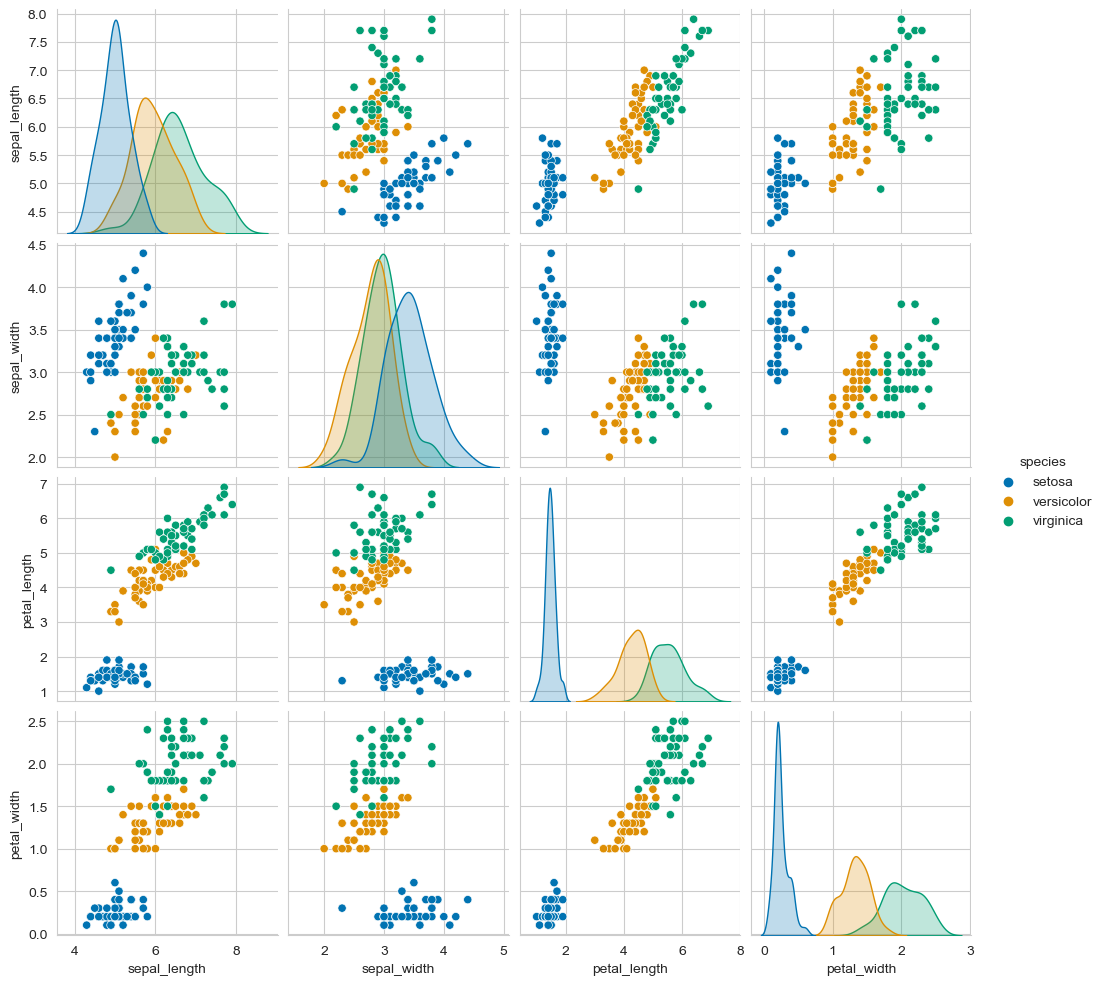

In [33]:
sns.pairplot(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
             hue = "species", diag_kind = 'kde')

Even better - there is an option to create a `PairGrid` which allows fine tuned control of the data as displayed above, below, and along the diagonal. In this way it becomes possible to avoid having symmetric redundancy, which is not all that informative. In the example below, we will show scatter plots and contour plots simultaneously. 

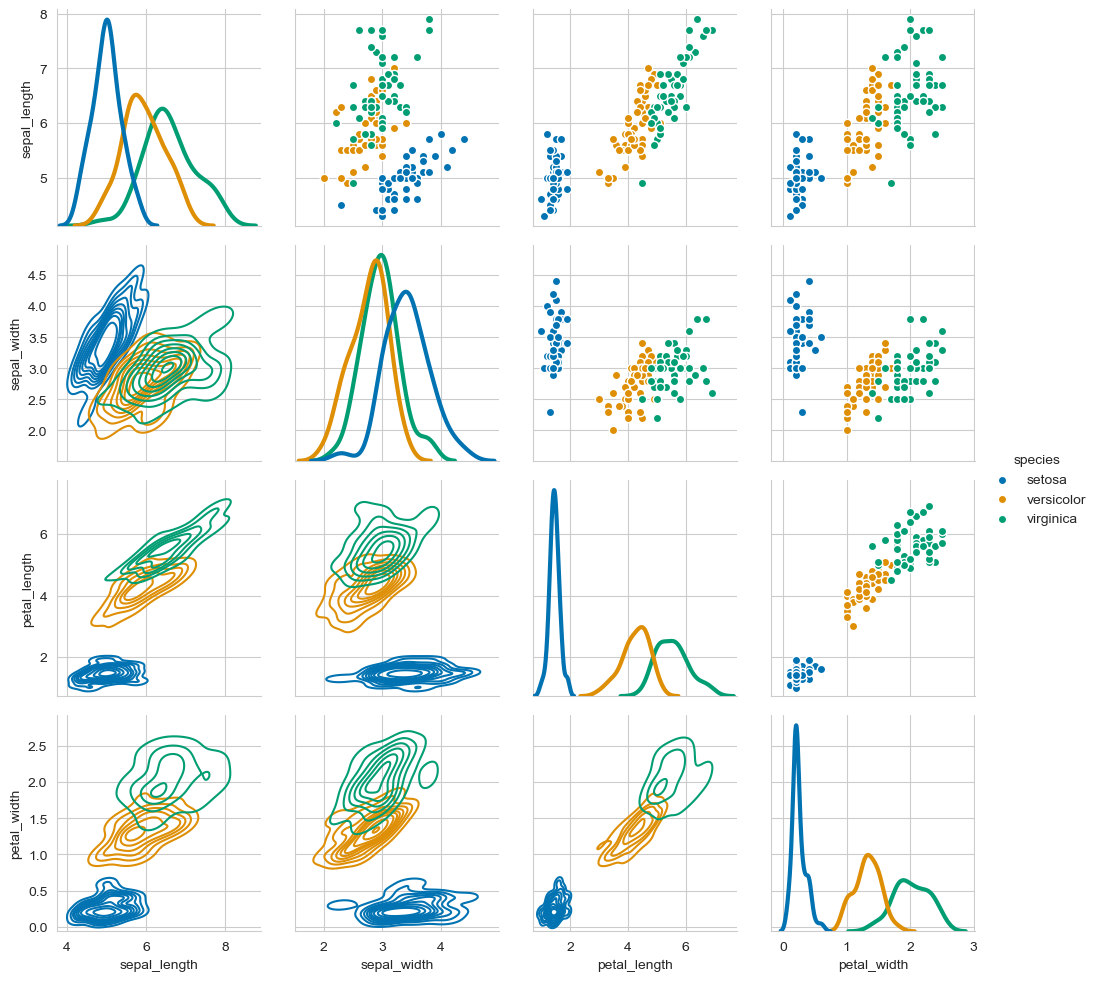

In [34]:
g = sns.PairGrid(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
                 hue = "species", diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, edgecolor='white')
g.map_diag(sns.kdeplot, lw=3)
g.add_legend()